# Figures for the hospitalization model

In [1]:
library(here)
source(here("setup.R"))


here() starts at /Users/stefan/workspace/work/phd/thesis



## Application 1: Showcase

In [53]:
df_files <- tibble(fname = list.files(here("data/results/4_hospitalizations/showcase"), full.names = T)) %>%
    # mutate(age_group = paste0("A", str_extract(fname, "\\d\\d-\\d\\d"))) %>%
    mutate(age_group = c("A00-04", "A00+", "A05-14", "A15-34", "A35-59", "A60-79", "A80+")) %>%
    mutate(n_delay = c(5, 8, 5, 7, 7, 8, 8))

read_age_predictions <- function(fname, n_delay) {
    dates <- seq(from = ymd("2021-11-22"), to = ymd("2022-04-28"), by = "1 day")
    variables <- c(
        "prob_hosp",
        paste0("p_delay_smooth", seq(n_delay)),
        paste0("p_delay", seq(n_delay)),
        "weekday_0",
        "weekday_1"
    )

    read_predictions(fname, dates, variables)
}

df_predictions <- df_files %>%
    mutate(data = map2(fname, n_delay, read_age_predictions)) %>%
    select(-fname, -n_delay) %>%
    unnest()


Warning message:
"`cols` is now required when using `unnest()`.
i Please use `cols = c(data)`."


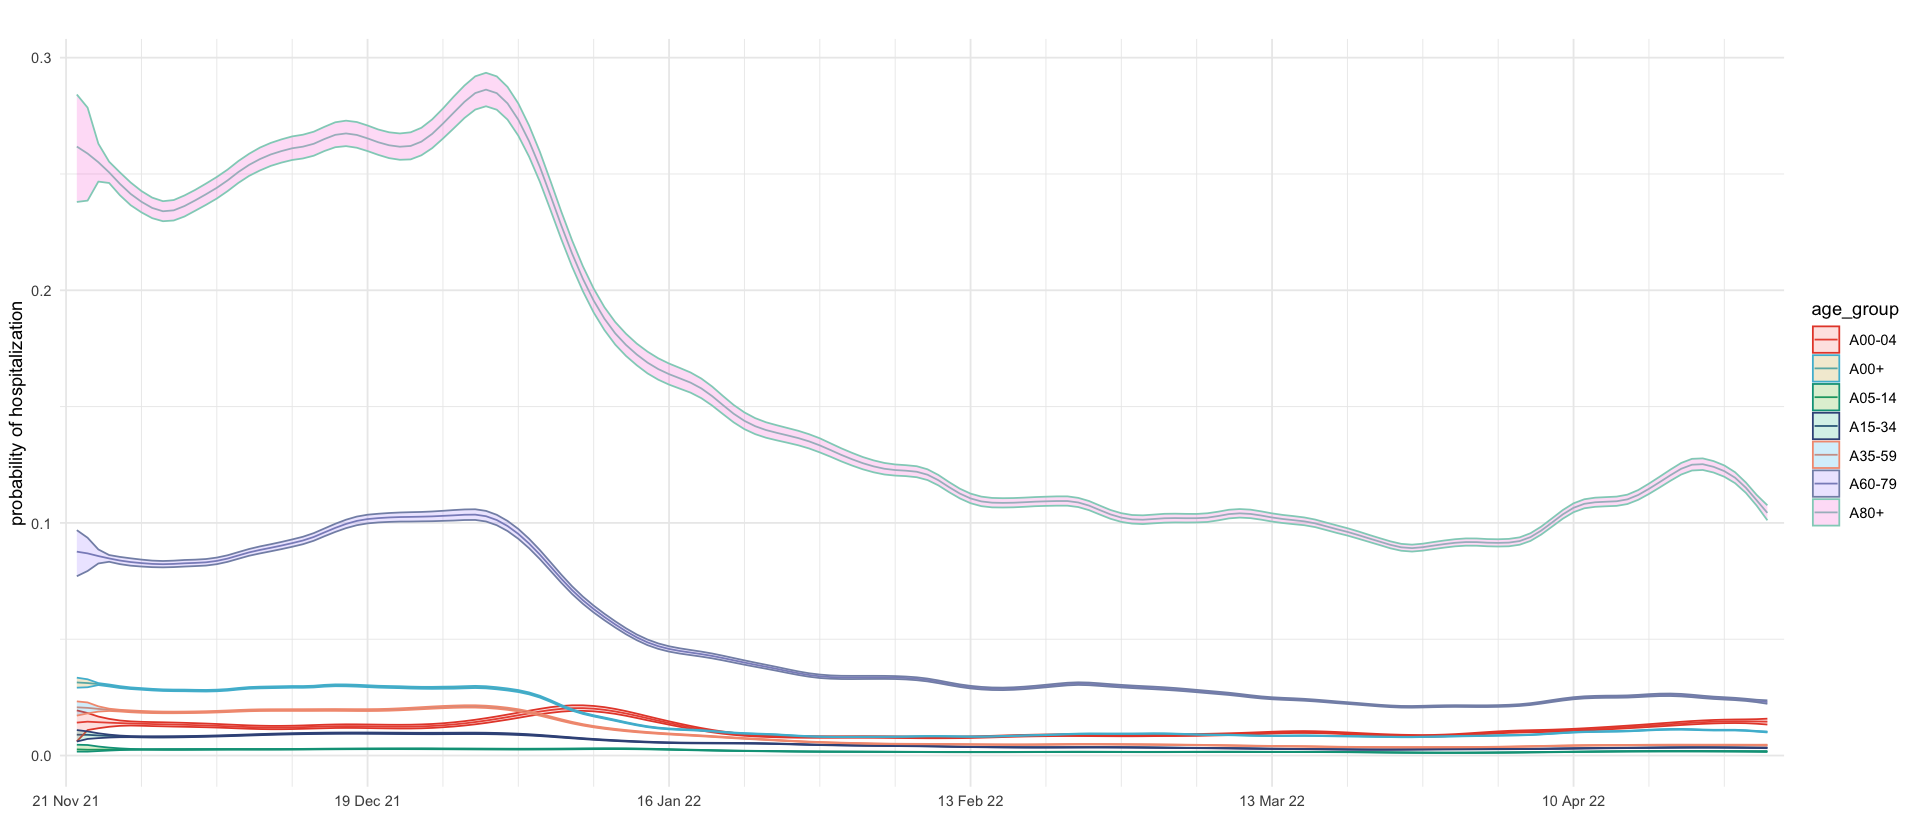

In [60]:
df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(variable == "prob_hosp") %>%
    mutate(age_group = factor(age_group)) %>%
    ggplot(aes(x = date, y = mean, color = age_group, group = age_group)) +
    geom_line() +
    geom_ribbon(aes(ymin = `0.025`, ymax = `0.975`, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = "probability of hospitalization"
    ) +
    scale_x_four_weekly()
